# 5. Hyper-parameter Tuning for Modeling

4 different models were fitted with the following training datasets to evalute data impact (class imbalance, number of samples) on modeling.
* using training data without augmentation (classes are imbalanced; varying from varying from 122 to 4406)
* using augementated training data (classes are imbalanced; varying from 915 to 4406)
* using Bootstrapping to draw 200 images from each class in the training data without augmentation for 5 times (classes are balanced)
* using Bootstrapping to draw 900 images from each class in the augmented training data for 5 times (classes are balanced)

Model performance was evaluted using the same testing data (unseen to models). The last model (model_4) showed the best performance.

**In this notebook, the following hyper-parameters are tuned for model_4 setup:**
Hyperband optimization algorithm is impletemend to improve tuning efficiency.
The following parameters are tuned:
* filter numbers in the 2nd `Conv2d`
* filter numbers in the 3rd `Conv2d`
* `rate` in `Dropout` layer
* `optimizer` method in `model.compile`

In [164]:
# Import dependencies
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imghdr
import random

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import SparseCategoricalAccuracy, SparseCategoricalCrossentropy

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

In [11]:
!pip install -q -U keras-tuner

In [23]:
import keras_tuner as kt

## 5.1. Load Testing Data
Testing data were splitted out from the origianl input in the feature engineering step.

Going to be used for evaluating performance of different models in this notebook.

In [3]:
# Load test data 
test_dir = '..\\data\\Plant_leave_diseases_dataset_without_augmentation_test_data'
print(f'Total number of classes is {len(os.listdir(test_dir))}.')

# Use batch to load in the images 
batch_size = 64
image_size = (128, 128)  # images are resized while reading
test_data = tf.keras.utils.image_dataset_from_directory(test_dir, batch_size = batch_size, image_size = image_size)
print(f'There are {len(test_data)} batches in the testing data.')

Total number of classes is 39.
Found 11077 files belonging to 39 classes.
There are 174 batches in the testing data.


In [4]:
# rescale the test data as required in the preprocessing step
test_data = test_data.map(lambda x, y: (x / 255, y))

## 5.2. Functions for Modle Ensembling

In [7]:
# define a function to return the most frequent unique value in a numpy array

def value_counts_np(arr):
    values, counts = np.unique(arr, return_counts = True)
    index = np.argmax(counts)
    return values[index]

In [8]:
# define a function to combine predictions from different models by majority vote
# This function output predicted labels

def bs_model_majority(X, model_name):
    y_pred_mv = []

    for i in range (1, 6):
        model = load_model(os.path.join('..\\models', f'{model_name}{i}.keras'))
        y_pred_prob = model.predict(X, verbose = 0)
        y_pred = np.argmax(y_pred_prob, axis = 1)
        y_pred_mv.append(y_pred)

    y_pred_mv = np.array(y_pred_mv).T
    y_pred_mv = np.apply_along_axis(value_counts_np, 1, y_pred_mv)
    return y_pred_mv

In [9]:
# define a function to combine predictions from different models by majority vote
# This function output predicted prabobilities for each label

def bs_model_majority_prob(X, model_name):
    y_pred_mv = []

    for i in range (1, 6):
        model = load_model(os.path.join('..\\models', f'{model_name}{i}.keras'))
        y_pred_prob = model.predict(X, verbose = 0)
        y_pred_mv.append(y_pred_prob)

    y_pred_mv = np.array(y_pred_mv)
    y_pred_mv = np.apply_along_axis(value_counts_np, 0, y_pred_mv)
    
    return y_pred_mv

In [10]:
# define a metric calculation function

def metric_cal(model_name, metric_name, combined = True):
    for X, y in test_data:
        # make predictions
        if combined:
            y_hat = bs_model_majority_prob(X, model_name)
        else:
            model = load_model(os.path.join('..\\models', str(model_name)))
            y_hat = model.predict(X, verbose = 0)
        # update the metrics
        metric_name.update_state(y, y_hat)
        # return output
    return metric_name.result().numpy()

In [173]:
# define a metric calculation function

def metric_tf(y, yhat, metric_name):
    metric_name.update_state(y, yhat)
    return metric_name.result().numpy()

In [176]:
# define a function to get preidctions for test data using multiple models

def comb_model_predict(model_name, test_data):
    y_pred_tuned = []
    y_prob_tuned = []
    y_test = []
    
    # make predictions batch by batch and store the results
    for X, y in test_data:
        y_proba_batch = bs_model_majority_prob(X, model_name)
        
        # add predictions to lists
        y_prob_tuned.extend(y_proba_batch)
        y_pred_tuned.extend(np.argmax(y_proba_batch, axis = 1))
        
        # add true labels to list
        y_test.extend(y.numpy())
        
    yhat_tuned = np.array(y_pred_tuned)
    yhat_prob_tuned = np.array(y_prob_tuned)
    y_true = np.array(y_test)
    
    return yhat_tuned, yhat_prob_tuned, y_true

## 5.3. Hyper-parameter Tuning
Model 4 setup included bootstrapping to draw 900 images from each class in the augmented training data for 5 times which already required a lot fo resource. 

In order to save computational cost, only 1 bootstrapping training set is chosen for hyper-parameter tuning purpose.

### 5.3.1. Load training data

In [16]:
# chooose the first bootstrapping training data
i = 1

# Define the training data directory
data_dir = '..\\data\\Plant_leave_diseases_dataset_with_augmentation_train_data_bs_' + str(i)
print(f'Total number of classes is {len(os.listdir(data_dir))}.')

# Use batch to load in the images 
batch_size = 64
image_size = (128, 128)  # images are resized while reading
data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size = batch_size, image_size = image_size)

# Apply the scaling in the preprocessing
data = data.map(lambda x, y : (x / 255, y))
print(f'Input training data length is {len(data)}.')

# Split the training data into training and validation
train_size = int(0.7*len(data)) 
val_size = int(0.3*len(data))

train = data.take(train_size)
val = data.skip(train_size).take(val_size)

print(f'Training data length is {len(train)}, validation data length is {len(val)}.')

Total number of classes is 39.
Found 35100 files belonging to 39 classes.
Input training data length is 549.
Training data length is 384, validation data length is 164.


### 5.3.2. Hyper-parameter tuning with random search
Hyperband algorithm is used isntead of grid or random search to optimize the computational cost.

The tunning process is automated by using `keras_tuner.Hyperband`. 

In [120]:
# define a function to build the model

def get_model(hp):    
    # Create the CNN model
    model = Sequential()
    
    # Add layers to the mode
    model.add(Conv2D(32, (3,3), 1, activation = 'relu', input_shape = (128,128,3)))
    model.add(MaxPooling2D())
    # create different choices for filter# in conv layer
    hp_filter_1 = hp.Int('filter_1', min_value = 16, max_value = 32, step = 8)
    model.add(Conv2D(hp_filter_1, (3,3), 1, activation = 'relu'))
    model.add(MaxPooling2D())
    # create different choices for filter# in conv layer
    hp_filter_2 = hp.Int('filter_2', min_value = 8, max_value = 32, step = 8)
    model.add(Conv2D(hp_filter_2, (3,3), 1, activation = 'relu'))
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    # create different choices for dropout
    hp_dropout_rate = hp.Choice('rate', values = [0.1, 0.2, 0.3, 0.4])
    model.add(Dropout(rate = hp_dropout_rate))
    model.add(Dense(39, activation = 'softmax'))    
    
    # Create different choices for optimizer in compile
    hp_optimizer = hp.Choice('optimizer', values = ['adam', 'sgd'])
    model.compile(hp_optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [121]:
import shutil
shutil.rmtree('ktdir')

In [122]:
# Create the random search
tuner = kt.Hyperband(get_model, 
                     objective = 'val_loss', 
                     max_epochs = 10, # max_epochs for each configuration
                     factor = 3, # 1/3 top configurations retained in each round
                     directory  = 'ktdir',
                     project_name = 'test')

In [123]:
# Set a early stop to further reduce searching time
stop = EarlyStopping(monitor = 'val_loss', patience = 3)

In [124]:
# Start the search
tuner.search(train, epochs = 30, validation_data = val, callbacks = [stop])

Trial 30 Complete [00h 35m 09s]
val_loss: 0.5934807658195496

Best val_loss So Far: 0.42063257098197937
Total elapsed time: 06h 43m 07s


In [125]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
# print out the best parameters
hp_list = ['optimizer', 'filter_1', 'filter_2', 'rate']
for item in hp_list:
    print('The best' + item + 'is {}.'.format(best_hps.get(item)))

The bestoptimizeris adam.
The bestfilter_1is 16.
The bestfilter_2is 32.
The bestrateis 0.1.


## 5.4. Modeling with Best Parameters

The best parameters found by `Hyperband` are used to build new models using 5 bootstrapping training data (model_4 setup).

In [126]:
# loop over 5 bootstrapping training data to train 5 models

for i in range(1, 6):
    
    print(f"Start of {i} sampling ----------------------------------")

    # Define the training data directory
    data_dir = '..\\data\\Plant_leave_diseases_dataset_with_augmentation_train_data_bs_' + str(i)
    print(f'Total number of classes is {len(os.listdir(data_dir))}.')

    # Use batch to load in the images 
    batch_size = 64
    image_size = (128, 128)  # images are resized while reading
    data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size = batch_size, image_size = image_size)

    # Apply the scaling in the preprocessing
    data = data.map(lambda x, y : (x / 255, y))
    print(f'Input training data length is {len(data)}.')

    # Split the training data into training and validation
    train_size = int(0.7*len(data)) 
    val_size = int(0.3*len(data))

    train = data.take(train_size)
    val = data.skip(train_size).take(val_size)

    print(f'Training data length is {len(train)}, validation data length is {len(val)}.')

    model = tuner.hypermodel.build(best_hps)

    # Fit the model
    hist = model.fit(train, epochs = 15, validation_data = val)

    # test score
    test_loss, test_acc = model.evaluate(test_data)
    print(f'The accuracy on test data is {test_acc}.')
    
    # save out model
    model_name = f'hyperband_model4_bs{i}.keras'
    model.save(os.path.join('..\\models', model_name))# Fit the model

Start of 1 sampling ----------------------------------
Total number of classes is 39.
Found 35100 files belonging to 39 classes.
Input training data length is 549.
Training data length is 384, validation data length is 164.
Epoch 1/15
384/384 [==============================] - 181s 468ms/step - loss: 2.0552 - accuracy: 0.4240 - val_loss: 1.2765 - val_accuracy: 0.6213
Epoch 2/15
384/384 [==============================] - 182s 474ms/step - loss: 1.0681 - accuracy: 0.6781 - val_loss: 0.7886 - val_accuracy: 0.7631
Epoch 3/15
384/384 [==============================] - 179s 465ms/step - loss: 0.7605 - accuracy: 0.7703 - val_loss: 0.7812 - val_accuracy: 0.7563
Epoch 4/15
384/384 [==============================] - 174s 452ms/step - loss: 0.6075 - accuracy: 0.8132 - val_loss: 0.5669 - val_accuracy: 0.8329
Epoch 5/15
384/384 [==============================] - 175s 456ms/step - loss: 0.4737 - accuracy: 0.8487 - val_loss: 0.4910 - val_accuracy: 0.8506
Epoch 6/15
384/384 [==========================

In [249]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 16)        4624      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 30, 30, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 14, 14, 32)       

### 5.4.3. Model evaluation

In [196]:
# make predictions
yhat_tuned, yhat_prob_tuned, y_true_tuned = comb_model_predict('hyperband_model4_bs', test_data)

In [201]:
# check the predictions
yhat_tuned.shape, yhat_prob_tuned.shape, y_true_tuned.shape

((11077,), (11077, 39), (11077,))

In [198]:
y_true_tuned[0]

38

In [199]:
yhat_tuned[0]

38

In [200]:
yhat_prob_tuned[0]

array([5.12962401e-08, 8.20443979e-09, 1.08295396e-07, 9.18085774e-10,
       1.62018001e-12, 4.62518999e-12, 1.99299652e-08, 1.58783442e-09,
       4.80010488e-14, 5.36597766e-10, 5.55531445e-12, 4.34960524e-15,
       2.34067729e-15, 1.78868896e-13, 1.36847396e-17, 2.55933043e-16,
       2.39426290e-13, 2.12497367e-10, 7.91044273e-14, 7.96920949e-12,
       2.99321982e-13, 1.04356814e-14, 2.74820555e-10, 6.39502507e-10,
       9.00369426e-15, 1.20197332e-15, 1.76462533e-09, 1.96364558e-13,
       2.43429663e-14, 2.14118046e-11, 7.15462267e-09, 2.50251926e-08,
       1.70243863e-09, 9.24309695e-09, 2.27058552e-13, 1.06936419e-13,
       3.86705639e-16, 7.83582588e-10, 9.71583366e-01], dtype=float32)

In [202]:
# get predictions using the untuned model
yhat_pre, yhat_prob_pre, y_true_pre = comb_model_predict('prelim_model4_bs', test_data)

In [203]:
# check the predictions
yhat_pre.shape, yhat_prob_pre.shape, y_true_pre.shape

((11077,), (11077, 39), (11077,))

In [205]:
y_true_pre[0]

17

In [206]:
yhat_pre[0]

17

In [207]:
yhat_prob_pre[0]

array([6.22354446e-10, 4.80889674e-14, 3.16434807e-08, 3.67313957e-11,
       5.93840244e-13, 1.11753096e-09, 1.82092617e-06, 6.95578374e-15,
       5.12270781e-10, 4.48202131e-14, 5.42782097e-10, 1.07344472e-20,
       7.50266776e-12, 8.76674018e-14, 1.28975284e-14, 2.14145428e-21,
       1.65962213e-08, 7.02711046e-01, 5.93336361e-13, 3.09607948e-08,
       4.83068663e-13, 1.19435447e-15, 2.13720208e-10, 1.32428849e-21,
       1.91939739e-13, 4.21785970e-18, 8.05820428e-12, 6.82555612e-09,
       8.99328897e-14, 5.44319960e-07, 2.16161197e-06, 2.03594664e-05,
       1.30997982e-03, 2.51872552e-04, 8.55532398e-12, 1.83161541e-11,
       5.35231166e-08, 2.61435245e-14, 4.16961740e-13], dtype=float32)

In [211]:
# create a table for accuracy, cross entropy for the two models
import pandas as pd

sca = SparseCategoricalAccuracy()
#sca.reset_state()
test_acc = metric_tf(y_true_tuned, yhat_prob_tuned, sca)
test_acc_4 = metric_tf(y_true_pre, yhat_prob_pre, sca)

scc = SparseCategoricalCrossentropy()
#scc.reset_state()
test_cros = metric_tf(y_true_tuned, yhat_prob_tuned, scc)
test_cros_4 = metric_tf(y_true_pre, yhat_prob_pre, scc)


acc_list = [round(test_acc, 3), round(test_acc_4, 3)]
cros_list = [round(test_cros, 3), round(test_cros_4, 3)]
models = ['tuned_model_4', 'prelim_model_4']

metric_df = pd.DataFrame({'accuracy': acc_list, 'cross_entropy': cros_list}, index = models)
metric_df

,accuracy,cross_entropy
tuned_model_4,0.909,0.441
prelim_model_4,0.896,0.450


In [245]:
# let add AUC (one over the rest) to the tabble

yhat_prob_pre_mdfy = np.zeros(yhat_prob_pre.shape)
for i in range(yhat_prob_pre.shape[0]):
    yhat_prob_pre_mdfy[i] = yhat_prob_pre[i] / yhat_prob_pre[i].sum()
    
yhat_prob_tuned_mdfy = np.zeros(yhat_prob_tuned.shape)
for i in range(yhat_prob_tuned.shape[0]):
    yhat_prob_tuned_mdfy[i] = yhat_prob_tuned[i] / yhat_prob_tuned[i].sum()

auc_ovr_pre = roc_auc_score(y_true_pre, yhat_prob_pre_mdfy, multi_class='ovr')
auc_ovr_tuned = roc_auc_score(y_true_tuned, yhat_prob_tuned_mdfy, multi_class='ovr')

metric_df['AUC_ovr'] = [auc_ovr_tuned, auc_ovr_pre]
metric_df

,accuracy,cross_entropy,AUC_ovr
tuned_model_4,0.909,0.441,0.997167
prelim_model_4,0.896,0.450,0.995729


**Tuned model performed better compared to the prelimary model which followed the setup the journal paper used.**

**Test data is imbalanced for this task, better to evaluate the following metrics:**
* Confusion Matrix
* Classification report

In [212]:
# calcualte confusion matrix for tuned model 4

# ensure the lengths match
assert yhat_tuned.shape == y_true_tuned.shape, f"Shape mismatch: y_hat {yhat_tuned.shape}, y_true {y_true_tuned.shape}"

conf_matrix = confusion_matrix(y_true_tuned, yhat_tuned)
print(conf_matrix)

[[ 101    6    0 ...    0    0    0]
 [   0  118    0 ...    0    0    0]
 [   0    0   39 ...    2    0    0]
 ...
 [   0    0    1 ... 1024    0    0]
 [   0    0    0 ...    0   70    0]
 [   0    0    1 ...    0    0  306]]


In [213]:
# calcualte confusion matrix for preliminary model 4

# ensure the lengths match
assert yhat_pre.shape == y_true_pre.shape, f"Shape mismatch: y_hat {yhat_pre.shape}, y_true {y_true_pre.shape}"

conf_matrix_pre = confusion_matrix(y_true_pre, yhat_pre)
print(conf_matrix_pre)

[[ 101    3    2 ...    0    0    0]
 [   1  106    0 ...    0    1    0]
 [   0    0   35 ...    3    0    0]
 ...
 [   0    0    1 ... 1006    0    0]
 [   0    0    0 ...    0   69    0]
 [   0    0    1 ...    0    0  307]]


In [214]:
# calculate classification report for tuned model 4
class_report = classification_report(y_true_tuned, yhat_tuned)
print(class_report)

              precision    recall  f1-score   support

           0       0.72      0.80      0.76       126
           1       0.75      0.95      0.84       124
           2       0.80      0.71      0.75        55
           3       0.85      0.89      0.87       329
           4       0.94      0.90      0.92       228
           5       0.92      0.96      0.94       300
           6       0.93      0.95      0.94       210
           7       0.91      0.96      0.93       170
           8       0.65      0.65      0.65       102
           9       0.97      0.99      0.98       238
          10       0.79      0.86      0.83       197
          11       0.97      0.97      0.97       232
          12       0.90      0.92      0.91       236
          13       0.95      0.94      0.95       276
          14       0.99      0.96      0.97       215
          15       0.91      0.98      0.94        84
          16       0.99      0.98      0.98      1101
          17       0.96    

In [215]:
# calculate classification report for preliminary model 4
class_report_pre = classification_report(y_true_pre, yhat_pre)
print(class_report_pre)

              precision    recall  f1-score   support

           0       0.69      0.80      0.74       126
           1       0.80      0.85      0.83       124
           2       0.71      0.64      0.67        55
           3       0.80      0.79      0.79       329
           4       0.92      0.89      0.90       228
           5       0.90      0.94      0.92       300
           6       0.91      0.95      0.93       210
           7       0.84      0.92      0.88       170
           8       0.67      0.54      0.60       102
           9       0.95      1.00      0.97       238
          10       0.80      0.86      0.83       197
          11       0.97      0.99      0.98       232
          12       0.83      0.92      0.87       236
          13       0.95      0.91      0.93       276
          14       0.95      0.96      0.96       215
          15       0.92      0.92      0.92        84
          16       0.97      0.96      0.97      1101
          17       0.90    

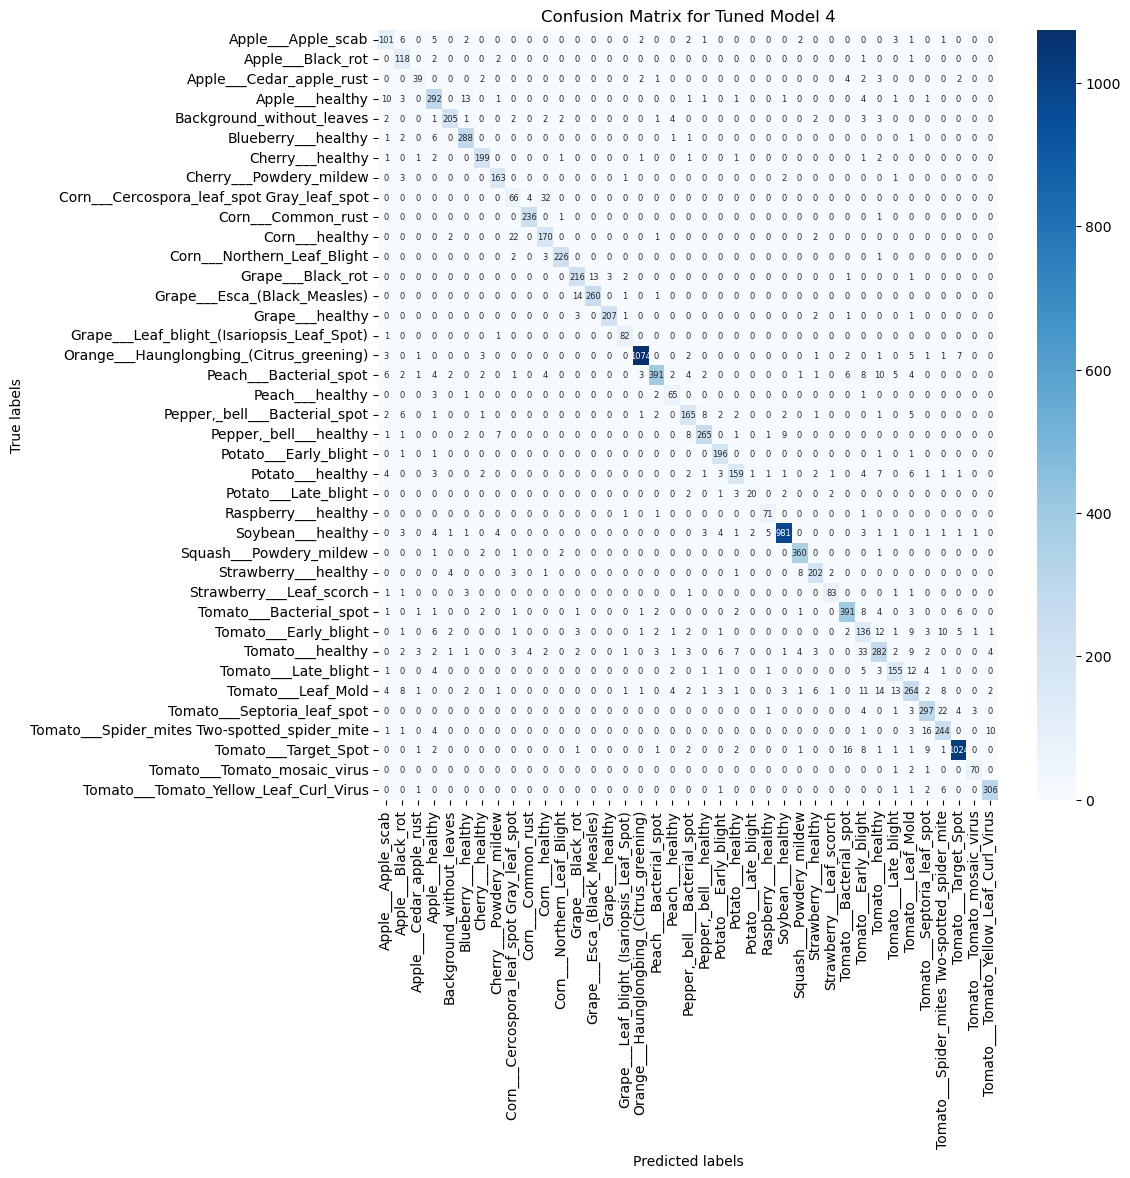

In [217]:
# plot confusion matrix for tuned model 4
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 6}, fmt='g', cmap='Blues', 
            xticklabels=os.listdir(test_dir), 
            yticklabels=os.listdir(test_dir))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Tuned Model 4')
plt.show()

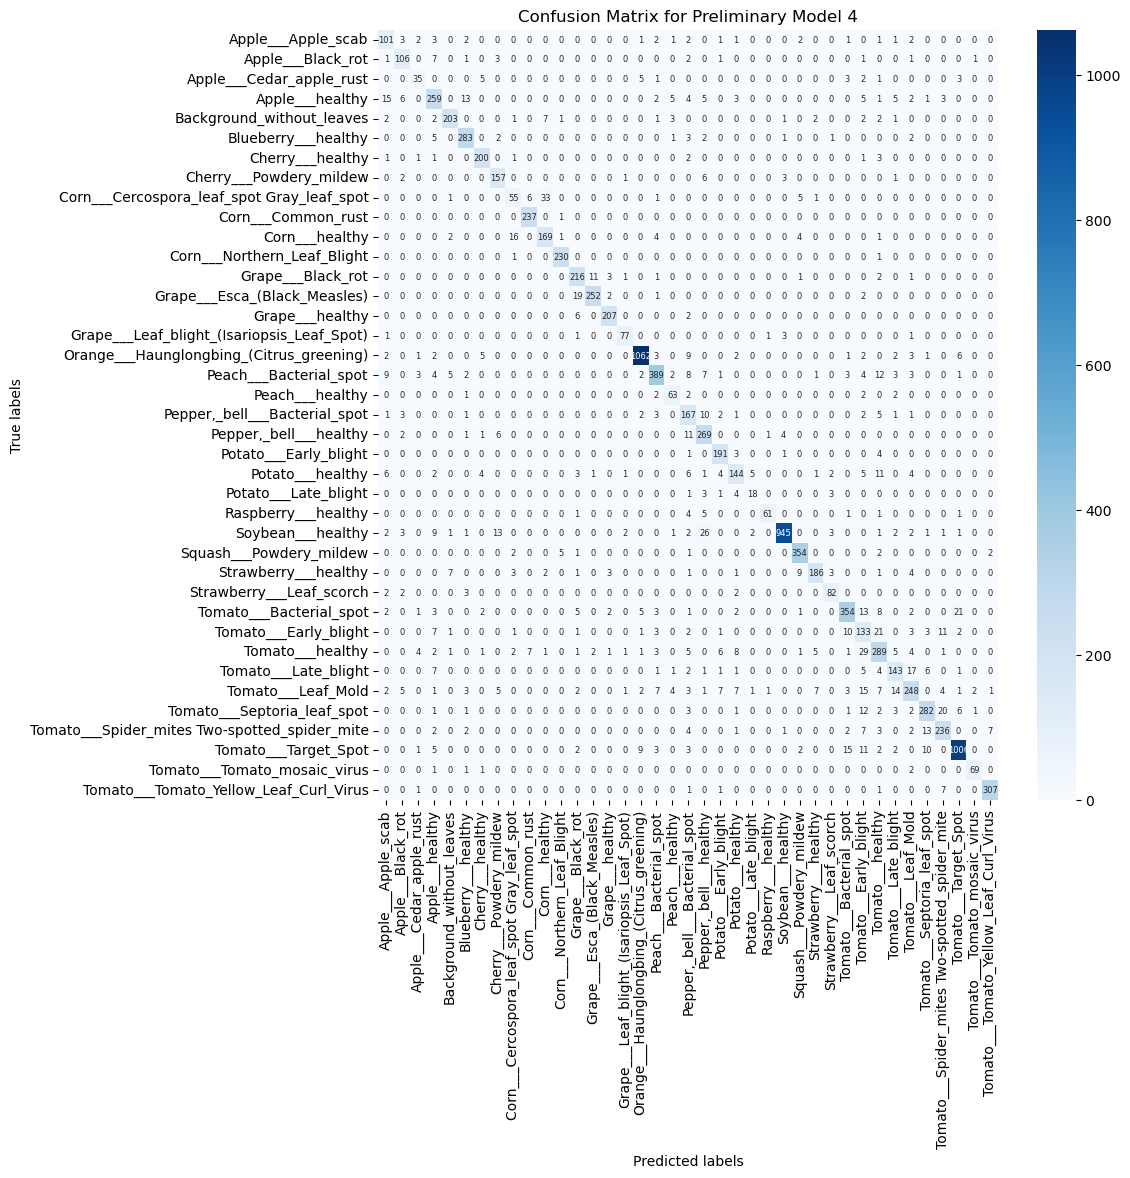

In [218]:
# plot confusion matrix for preliminary model 4
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix_pre, annot = True, annot_kws={'size': 6}, fmt='g', cmap='Blues', 
            xticklabels=os.listdir(test_dir), 
            yticklabels=os.listdir(test_dir))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Preliminary Model 4')
plt.show()

## 5.5. Summary

* The hyperband optimization algorithm worked pretty good optimizing multiple hyper-parameters together with an efficient use of avaialble reources.
* The tuned model performed better with improved predictions for classes for which the preliminary model performed poorly.
* The tuned model suggested more covolution filters for the 2nd and 3rd `Cov2D` which is consistent with what commonly suggested.
* If more resources avaliable, more hyper-parameters can be tuned, such as more filters for convolution, learning rate for optimizer.
